In [6]:
from typing import List, Optional
import os
import faiss
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch
from torch import Tensor
import torch.nn.functional as F
import ijson
from tqdm.auto import tqdm

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import pickle

class RAG:

    def __init__(
        self,
        embedder_name: str = "Qwen/Qwen3-Embedding-0.6B",
        reranker_name: str = "Qwen/Qwen3-Reranker-0.6B",
        chunk_size: int = 500,
        chunk_overlap: int = 125,
        device: Optional[str] = None,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(self.device)
        self.embedder.eval()

        self.rr_tokenizer = AutoTokenizer.from_pretrained(reranker_name, padding_side='left')
        self.reranker = AutoModelForCausalLM.from_pretrained(reranker_name).to(self.device)
        self.reranker.eval()

        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap,)
        self.index = None
        self.doc_store = []

        self.max_length = 1024
        self.token_false_id = self.rr_tokenizer.convert_tokens_to_ids("no")
        self.token_true_id = self.rr_tokenizer.convert_tokens_to_ids("yes")
        prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
        suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
        self.prefix_tokens = self.rr_tokenizer.encode(prefix, add_special_tokens=False)
        self.suffix_tokens = self.rr_tokenizer.encode(suffix, add_special_tokens=False)

    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        inputs = self.emb_tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=self.max_length,
        ).to(self.device)

        with torch.no_grad():
            outputs = self.embedder(**inputs)

        embeddings = self.last_token_pool(outputs.last_hidden_state, inputs.attention_mask)
        embeddings = embeddings.float().cpu()  # <-- ключевая строка

        return F.normalize(embeddings, p=2, dim=1).numpy()


    @staticmethod
    def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[
                torch.arange(batch_size, device=last_hidden_states.device),
                sequence_lengths] 

    def load_and_process_arxiv_json(self, file_path: str, split: bool = False) -> List[Document]:
        ext = os.path.splitext(file_path)[1].lower()
        if ext != ".json":
            raise ValueError(f"Expected .json file, got: {ext}")

        docs: List[Document] = []
        with open(file_path, "r", encoding="utf-8") as f:
            for obj in ijson.items(f, "item"):
                arxiv_id = obj.get("id")
                title = (obj.get("title") or "").strip()
                abstract = (obj.get("abstract") or "").strip()
                text = (title + "\n" + abstract).strip()
                meta = {
                    "id": arxiv_id,
                    "title": title,
                    "categories": obj.get("categories"),
                    "doi": obj.get("doi"),
                    "journal_ref": obj.get("journal-ref"),
                    "update_date": obj.get("update_date"),
                }

                docs.append(Document(page_content=text, metadata=meta))

        return self.text_splitter.split_documents(docs) if split else docs

    def build_index(self, file_path: str, batch_size: int = 64) -> None:
        all_docs = self.load_and_process_arxiv_json(file_path, split=False)
        self.doc_store = all_docs
        embs = []
        for i in tqdm(range(0, len(all_docs), batch_size), desc="Embedding corpus", unit="batch"):
            batch_texts = [d.page_content for d in all_docs[i:i + batch_size]]
            embs.append(self._generate_embeddings(batch_texts))
        embeddings = np.concatenate(embs, axis=0).astype("float32")
        self.index = faiss.IndexFlatIP(embeddings.shape[1])
        self.index.add(embeddings)

    @staticmethod
    def get_detailed_instruct(task_description: str, query: str):
        return f'Instruct: {task_description}\nQuery:{query}'

    @staticmethod
    def format_reranker_instruction(query, doc, instruction=None):
        if instruction is None:
            instruction = 'Given a web search query, retrieve relevant passages that answer the query'
        output = "<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}".format(
            instruction=instruction, query=query, doc=doc)
        return output

    def process_inputs(self, pairs):
        """Обработка данных для реранкера"""
        inputs = self.rr_tokenizer(pairs,
                                   padding=False,
                                   truncation='longest_first',
                                   return_attention_mask=False,
                                   max_length=self.max_length -
                                   len(self.prefix_tokens) -
                                   len(self.suffix_tokens))
        for i, ele in enumerate(inputs['input_ids']):
            inputs['input_ids'][
                i] = self.prefix_tokens + ele + self.suffix_tokens
        inputs = self.rr_tokenizer.pad(inputs,
                                       padding=True,
                                       return_tensors="pt",
                                       max_length=self.max_length)

        # переносим тензоры на девайс ранжирующей модели
        for key in inputs:
            inputs[key] = inputs[key].to(self.device)
        return inputs

    def search(self,
               query: str,
               k: int = 5,
               task: str = None):
        if self.index is None:
            raise ValueError("Index not initialized")

        if task is None:
            task = 'Given a web search query, retrieve relevant passages that answer the query'

        query_embedding = self._generate_embeddings([query])
        distances, indices = self.index.search(query_embedding, k)
        return distances, indices         

    @torch.no_grad()
    def compute_logits(self, inputs):
        batch_scores = self.reranker(**inputs).logits[:, -1, :]
        true_vector = batch_scores[:, self.token_true_id]
        false_vector = batch_scores[:, self.token_false_id]
        batch_scores = torch.stack([false_vector, true_vector], dim=1)
        batch_scores = torch.nn.functional.log_softmax(batch_scores, dim=1)
        scores = batch_scores[:, 1].exp().tolist()
        return scores

    def rerank(self, query: str, documents: List[str], batch_size=4):
        pairs = []
        for d in documents:
            pairs.append(self.format_reranker_instruction(query, d))

        scores = []
        for i in range(0, len(pairs), batch_size):
            inputs = self.process_inputs(pairs[i:i + batch_size])
            sc = self.compute_logits(inputs)
            scores.extend(sc)
        return scores
    
def save(self, prefix: str) -> None:
    if self.index is None:
        raise ValueError("Index not initialized")
    faiss.write_index(self.index, prefix + ".index")
    with open(prefix + ".docstore.pkl", "wb") as f:
        pickle.dump(self.doc_store, f)

def load(self, prefix: str) -> None:
    self.index = faiss.read_index(prefix + ".index")
    with open(prefix + ".docstore.pkl", "rb") as f:
        self.doc_store = pickle.load(f)    

In [ ]:
q = "A trap under radiation of two traveling"

k = 5
rag = RAG(device="cuda")
rag.build_index("./arxiv-metadata-s.json")

D, I = rag.search(q, k=k)
candidates = [rag.doc_store[i].page_content for i in I[0]]

for c in candidates:
    print(c[:800])
    print("-#" * 20)
    print()

In [ ]:
import faiss
import pickle

prefix = "arxiv_rag_qwen3"

rag = RAG(device="cuda")
rag.index = faiss.read_index(prefix + ".index")

with open(prefix + ".docstore.pkl", "rb") as f:
    rag.doc_store = pickle.load(f)

print("Loaded. docs:", len(rag.doc_store), "index size:", rag.index.ntotal)

Loaded. docs: 98213 index size: 98213


In [ ]:
import numpy as np

ntotal = rag.index.ntotal
dim = rag.index.d
bytes_index = ntotal * dim * 4

print("faiss dim:", dim)
print("index vectors:", ntotal)
print("approx faiss vectors size (MB):", bytes_index / (1024**2))


faiss dim: 1024
index vectors: 98213
approx faiss vectors size (MB): 383.64453125


In [ ]:
import faiss
import pickle

prefix = "arxiv_rag_qwen3"

faiss.write_index(rag.index, prefix + ".index")

with open(prefix + ".docstore.pkl", "wb") as f:
    pickle.dump(rag.doc_store, f)



Saved: arxiv_rag_qwen3.index and arxiv_rag_qwen3.docstore.pkl


In [9]:
import time

def profile_query(rag, query: str, retrieve_k: int = 50, rr_batch_size: int = 4):
    t0 = time.perf_counter()
    q_emb = rag._generate_embeddings([query])
    t1 = time.perf_counter()

    _, I = rag.index.search(q_emb.astype("float32"), retrieve_k)
    t2 = time.perf_counter()

    idxs = [int(x) for x in I[0]]
    cand_docs = [rag.doc_store[i] for i in idxs]
    cand_texts = [d.page_content for d in cand_docs]
    t3 = time.perf_counter()

    scores = rag.rerank(query, cand_texts, batch_size=rr_batch_size)
    t4 = time.perf_counter()

    ranked = sorted(zip(cand_docs, scores), key=lambda x: x[1], reverse=True)[:5]
    ranked_ids = [d.metadata.get("id") for d, _ in ranked]
    t5 = time.perf_counter()

    timing = {
        "query_embed_s": t1 - t0,
        "faiss_search_s": t2 - t1,
        "gather_candidates_s": t3 - t2,
        "rerank_s": t4 - t3,
        "sort_top5_s": t5 - t4,
        "total_s": t5 - t0,
    }
    return ranked_ids, timing

In [27]:
import pandas as pd
import numpy as np

def eval_mrr5(
    rag,
    test_csv_path: str,
    retrieve_k: int = 50,
    rr_batch_size: int = 4,
    limit: int | None = None,
):
    df = pd.read_csv(test_csv_path)
    if limit is not None:
        df = df.head(limit)

    mrrs = []
    timings = {k: [] for k in ["query_embed_s","faiss_search_s","gather_candidates_s","rerank_s","sort_top5_s","total_s"]}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="MRR@5", unit="query"):
        query = row["query"]
        gold_id = row["id"]

        ranked_ids, t = profile_query(rag, query, retrieve_k=retrieve_k, rr_batch_size=rr_batch_size)

        rr = 0.0
        for rnk, rid in enumerate(ranked_ids, start=1):
            if rid == gold_id:
                rr = 1.0 / rnk
                break
        mrrs.append(rr)

        for k in timings:
            timings[k].append(t[k])

    def summarize(arr):
        arr = np.array(arr, dtype=np.float64)
        return {
            "mean": float(arr.mean()),
            "p50": float(np.percentile(arr, 50)),
            "p95": float(np.percentile(arr, 95)),
        }

    return {
        "n": len(df),
        "MRR@5": float(np.mean(mrrs)),
        "params": {"retrieve_k": retrieve_k, "rr_batch_size": rr_batch_size},
        "timings_per_query": timings,
        "timings_summary": {k: summarize(v) for k, v in timings.items()},
    }


In [28]:
res = eval_mrr5(rag, "test_sample.csv", retrieve_k=50, rr_batch_size=4, limit=50)
print(res)


MRR@5:   0%|          | 0/50 [00:00<?, ?query/s]/home/ubuntu/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
MRR@5: 100%|██████████| 50/50 [01:31<00:00,  1.82s/query]

{'n': 50, 'MRR@5': 0.9866666666666666, 'params': {'retrieve_k': 50, 'rr_batch_size': 4}, 'timings_per_query': {'query_embed_s': [0.029838979000487598, 0.025186472999848775, 0.02536106200022914, 0.02523672200004512, 0.025299781998910476, 0.026805231000253116, 0.02615770099873771, 0.02878055799919821, 0.025173361000270233, 0.026257740000801277, 0.026581620000797557, 0.02533481099999335, 0.026698259000113467, 0.025705039999593282, 0.025269190000472008, 0.026802009000675753, 0.02602496000145038, 0.0252122789988789, 0.02608557900020969, 0.025211350000972743, 0.025304879000032088, 0.02602144800039241, 0.02575594799964165, 0.025915178999639465, 0.026535438000792055, 0.0257881269990321, 0.02544289899924479, 0.02540004799993767, 0.028368526000122074, 0.025111447999734082, 0.02548539800045546, 0.025560546999258804, 0.025606166998841218, 0.025529217999064713, 0.028334544000244932, 0.02602042699982121, 0.027890895000382443, 0.02768277500035765, 0.025387957000930328, 0.025755356000445317, 0.0308372

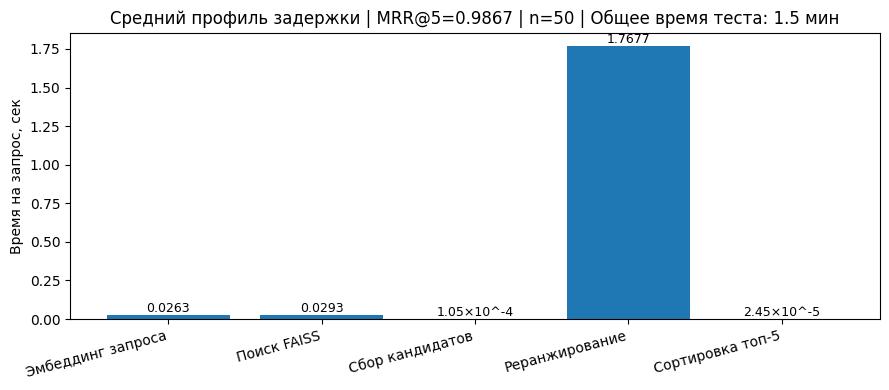

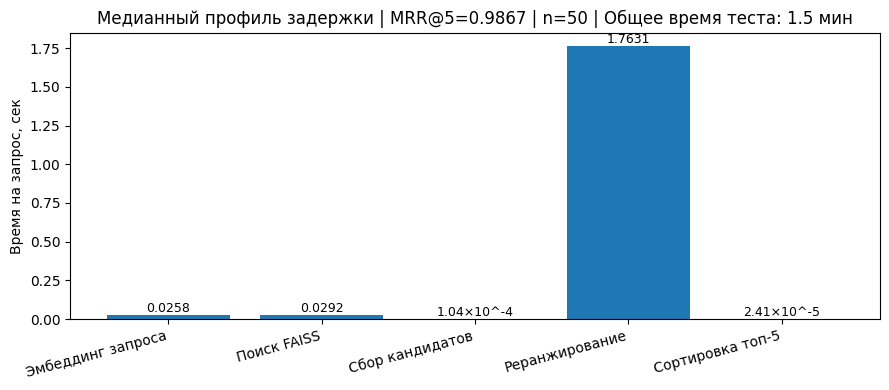

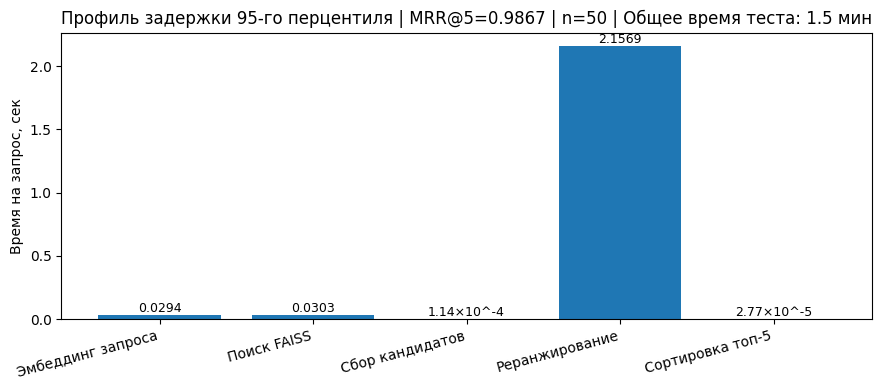

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def format_sci_ru(v: float) -> str:
    if v == 0:
        return "0"
    if abs(v) < 1e-3 or abs(v) >= 1e3:
        a, b = f"{v:.2e}".split("e")
        b = int(b)
        return f"{a}×10^{b}"
    return f"{v:.4f}"

def get_plot(res, title, stat="mean"):
    summary = res["timings_summary"]
    keys = ["query_embed_s", "faiss_search_s", "gather_candidates_s", "rerank_s", "sort_top5_s"]
    labels_ru = ["Эмбеддинг запроса", "Поиск FAISS", "Сбор кандидатов", "Реранжирование", "Сортировка топ-5"]
    vals = [summary[k][stat] for k in keys]

    total_test_s = float(np.sum(res["timings_per_query"]["total_s"]))

    plt.figure(figsize=(9, 4))
    bars = plt.bar(labels_ru, vals)
    plt.ylabel(f"Время на запрос, сек")
    plt.title(f"{title} | MRR@5={res['MRR@5']:.4f} | n={res['n']} | Общее время теста: {total_test_s/60:.1f} мин")
    plt.xticks(rotation=15, ha="right")

    for b, v in zip(bars, vals):
        plt.text(
            b.get_x() + b.get_width() / 2,
            b.get_height(),
            format_sci_ru(float(v)),
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


get_plot(res, "Cредний профиль задержки", stat="mean")
get_plot(res, "Медианный профиль задержки", stat="p50")
get_plot(res, "Профиль задержки 95-го перцентиля", stat="p95")